# Solving a costum unconstrained problem with BayeSQP


In [7]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from botorch.test_functions.base import BaseTestProblem

from bayesqp import BayeSQP, seed_everything

%matplotlib inline

In [8]:
# The following test function was generated with Claude
# For the same function under constraints, see costum_constrained_benchmark.ipynb


class MultiMinimaToyProblemCircle(BaseTestProblem):
    r"""Extended quadratic test function with multiple minima."""

    dim = 2  # Two-dimensional optimization problem
    _check_grad_at_opt = False
    _bounds = [(0.0, 4.0), (1.0, 6.0)]  # Bounds for the two dimensions

    def __init__(self, circle_center=[2, 3], circle_radius=1, noise_std=None):
        self.continuous_inds = list(range(self.dim))
        super().__init__(noise_std=noise_std)
        self.circle_center = np.array(circle_center)
        self.circle_radius = np.array(circle_radius)

    def _evaluate_true(self, X: torch.Tensor) -> torch.Tensor:
        """Objective function evaluation with multiple minima."""
        if isinstance(X, torch.Tensor):
            X = X.detach().numpy()  # Ensure correct conversion

        # Original quadratic term
        quadratic1 = (X[..., 0] - 3) ** 2 + (X[..., 1] - 2) ** 2

        # Additional quadratic terms to create multiple minima
        quadratic2 = 0.8 * ((X[..., 0] - 1) ** 2 + (X[..., 1] - 4) ** 2)
        quadratic3 = 1.2 * ((X[..., 0] - 2.5) ** 2 + (X[..., 1] - 4.5) ** 2)

        # Combine with a mixture function
        mixture = np.minimum(np.minimum(quadratic1, quadratic2), quadratic3)

        # Add sinusoidal perturbations to create more complex landscape
        perturbation1 = 0.1 * np.sin(5 * X[..., 0] + 3 * X[..., 1])
        perturbation2 = 0.15 * np.cos(3 * X[..., 0] - 2 * X[..., 1])

        # Combine everything
        result = mixture + perturbation1 + perturbation2

        # Add a terrain-like pattern for additional local minima
        terrain = 0.05 * np.sin(8 * X[..., 0]) * np.sin(8 * X[..., 1])

        return torch.tensor(result + terrain)

In [9]:
DIM = 2

func = MultiMinimaToyProblemCircle()

# These are all algorithm settings
general_config = {
    "tol": 1e-4,
    "local_sample_strategy": "sobol_sphere",
    "clamp_to_bounds": True,  # enforce bounds at all times
    "generate_local_samples_after_step": True,
    "K": "auto",  # auto: (DIM+1), int
    "n_initial": DIM,  # initial samples
    "delta_f": 0.2,  # for some problems, also higher values work well
    "epsilon": 0.05,
}

line_search_config = {
    "min_alpha": 0.0,
    "max_alpha": 1.0,
    "method": "posterior_sampling",
    "n_candidates": 100,
    "M": 3,
}

bayesqp = BayeSQP(
    objective_function=func,
    verbose_level=-1,  # -1: silent, 0: normal 1: normal + warnings, 2: debug
    general_config=general_config,
    line_search_config=line_search_config,
)

In [10]:
seed_everything(42)

# Define starting point
bounds = func.bounds
x0 = bounds[0] + torch.rand(DIM).reshape(1, -1) * (bounds[1] - bounds[0])

# Run optimization
result = bayesqp.minimize(x0, max_evals=50)

In [11]:
print(result)

BayeSQP Optimization Result

Optimization Status:
  Feasible:        ✓ Yes
  Function Evals:  50

Best Solution:
  Objective Value: -2.157067e-02
  Solution (x):    [2.279 , 4.4709]
  Best solution obtained at eval #45

Total Time: 3.4492 seconds


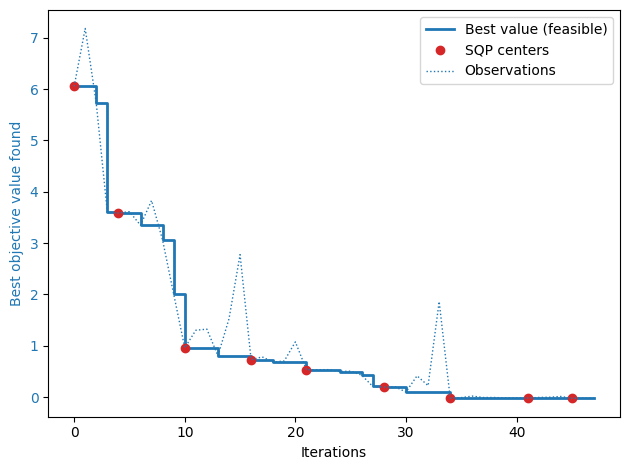

In [12]:
history = result.fun_history
x_history = result.x_history
step_x_history = result.step_history
is_feasible_history = result.feasible_history
constraint_values = np.array(result.constraint_values)

step_counter = 0
step_indieces = []

for i in range(len(x_history)):
    if np.allclose(x_history[i], step_x_history[step_counter]):
        step_indieces.append(i)
        step_counter += 1
        if step_counter >= len(step_x_history):
            break


fig, ax1 = plt.subplots()

# --- Primary axis (objective values)
n_evals = np.arange(0, len(history))
best_feasible_values = np.full_like(history, np.inf)
current_best = np.inf
for i in range(len(history)):
    if is_feasible_history[i] and history[i] < current_best:
        current_best = history[i]
    best_feasible_values[i] = current_best

best_values = best_feasible_values
ax1.step(
    n_evals,
    best_values,
    color="tab:blue",
    lw=2,
    where="post",
    label="Best value (feasible)",
)

ax1.plot(
    n_evals[step_indieces],
    history[step_indieces],
    color="tab:red",
    linestyle="None",
    marker="o",
    label="SQP centers",
)
ax1.plot(
    n_evals,
    history,
    color="tab:blue",
    linestyle="dotted",
    lw=1,
    label="Observations",
)
ax1.set_xlabel("Iterations")
ax1.set_ylabel("Best objective value found", color="tab:blue")
ax1.tick_params(axis="y", labelcolor="tab:blue")
ax1.legend(loc="upper right")
plt.tight_layout()
plt.show()

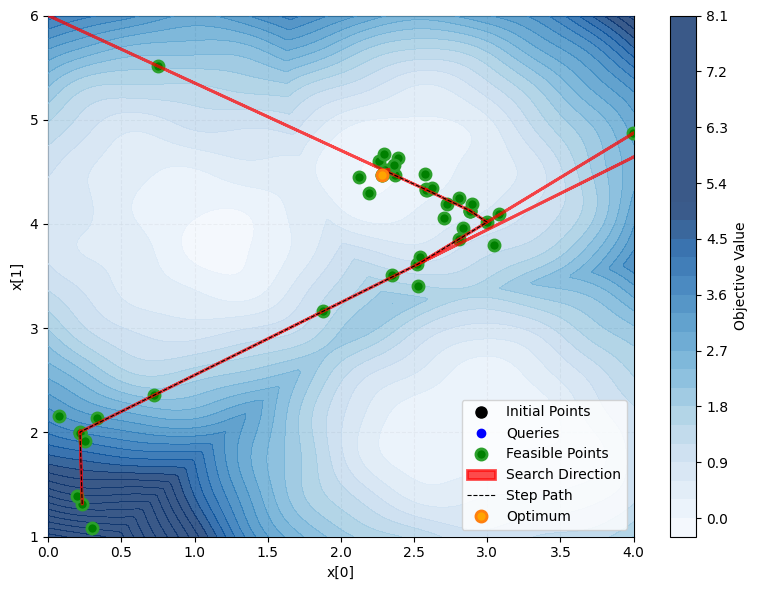

In [13]:
circle_center = func.circle_center
circle_radius = func.circle_radius
n_initial = result.info.n_initial
directions = result.info.directions

opt_solution = result.x


# Plot optimization path with contours
x_vals = np.linspace(0, 4, 200)  # Increased resolution for contours
y_vals = np.linspace(1, 6, 200)
X, Y = np.meshgrid(x_vals, y_vals)
Z = np.array(
    [
        func.evaluate_true(torch.tensor([xi, yi])).detach()
        for xi, yi in zip(np.ravel(X), np.ravel(Y))
    ]
).reshape(X.shape)


# Second plot: Zoomed view with direction arrows
plt.figure(figsize=(8, 6))

# Define domain limits
x_min, x_max = 0, 4
y_min, y_max = 1, 6

# Plot contours
contour = plt.contourf(X, Y, Z, levels=30, cmap="Blues", alpha=0.8, vmax=5, zorder=3)

# Plot optimization points
plt.plot(
    x_history[:n_initial, 0],
    x_history[:n_initial, 1],
    "ko",
    markersize=8,
    label="Initial Points",
    zorder=100,
)

plt.plot(
    x_history[n_initial:, 0],
    x_history[n_initial:, 1],
    "bo",
    markersize=6,
    label="Queries",
    zorder=101,
)

feasible_points = x_history[result.feasible_history]
for i, point in enumerate(feasible_points):
    plt.plot(
        point[0],
        point[1],
        "go",
        markersize=8,
        markeredgecolor="tab:green",
        markeredgewidth=2,
        zorder=101 + i,
        label="Feasible Points" if i == 0 else "",
    )

# Plot direction
for i, (point, direction) in enumerate(zip(step_x_history, directions)):
    plt.arrow(
        point[0],
        point[1],
        direction[0],
        direction[1],
        fc="red",
        ec="red",
        alpha=0.7,
        linewidth=2,
        zorder=200 + i,
        label="Search Direction" if i == 0 else "",
    )

# Plot step path
plt.plot(
    step_x_history[:, 0],
    step_x_history[:, 1],
    color="k",
    linestyle="--",
    linewidth=0.8,
    label="Step Path",
    zorder=10000,
)

# Plot optimum
plt.plot(
    opt_solution[0],
    opt_solution[1],
    "o",
    color="orange",
    markersize=8,
    markeredgecolor="tab:orange",
    markeredgewidth=2,
    label="Optimum",
    zorder=200000,
)

plt.xlabel("x[0]")
plt.ylabel("x[1]")
plt.legend(loc="best")
plt.xlim([0, 4])
plt.ylim([1, 6])
plt.grid(linestyle="--", alpha=0.6)
plt.colorbar(contour, label="Objective Value")
plt.tight_layout()